Creating environment

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ndcg_score # this is the scorer used by Kaggle to score the performance of our results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
import io
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DM/Assignment 2/training_set_VU_DM.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DM/Assignment 2/sample_train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DM/Assignment 2/test_set_VU_DM.csv')

Feature engineering

In [ ]:
def nanrate(train, valname):
    ## train, the dataset name
    ## valname, the feature name to study
    train[valname + "_na"] = pd.isnull(train[valname])
    book_rate=[]
    click_rate=[]
    c_summary=[]
    b_summary=[]
    cond = []
    for i, gb in train.groupby(valname+"_na"):
        if i:
            cond.append(1)
        else:
            cond.append(0)
        book_rate.append(gb["booking_bool"].mean())
        click_rate.append(gb["click_bool"].mean())
        c_summary.append(gb["click_bool"].describe())
        b_summary.append(gb["booking_bool"].describe())
    df = pd.DataFrame(np.array([cond, click_rate, book_rate]), index=["Condition","Click Rate", "Book Rate"])
    df = df.transpose()
    #print(df)
    df.plot( x="Condition",kind="bar")
    locs, labels = plt.xticks()
    plt.xticks(locs, ["Not NULL", "NULL"], size='small', rotation='horizontal')
    plt.title("Click and booking rate of non-NA samples and Null features, wrt:"+valname)
    plt.show()
    
def ratedist(train, name, steps, navalue):
    ## train, dataset name
    ## name, the feature name
    ## steps, the interval size we are going to split the feature data with
    ## navalue, a special value for the na samples, can be -1, or -100
    print("Here the NULL values are classed as "+str(navalue))
    train[name+"_step"] = np.round(train[name]/steps)
    train[name+"_step"][pd.isnull(train[name])] = navalue
    rate_list = []
    c_per_list = []
    b_per_list = []
    for rate, gp in train.groupby(name+"_step"):
        rate_list.append(rate)
        c_per_list.append(1.0*gp["click_bool"].mean())
        b_per_list.append(1.0*gp["booking_bool"].mean())
    df = pd.DataFrame(np.array([rate_list, c_per_list, b_per_list]), index=["levels","c_per", "b_per"])
    df = df.transpose()
    
    df.plot(x="levels", y="c_per", kind="bar")
    plt.title("Click rate against "+name)    
    plt.show()
    
    df.plot(x="levels", y="b_per", kind="bar")
    plt.title("Booking rate against "+name)
    plt.show()

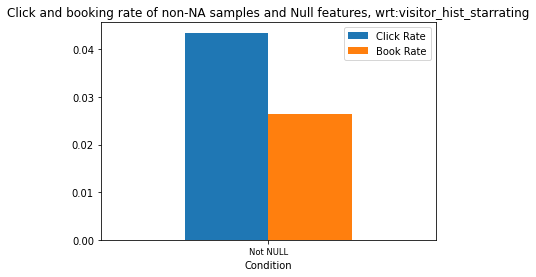

Here the NULL values are classed as -1


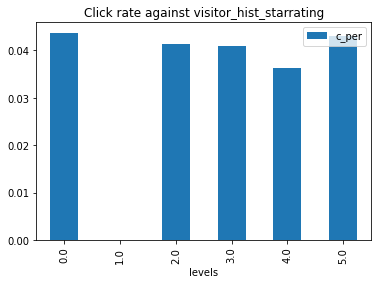

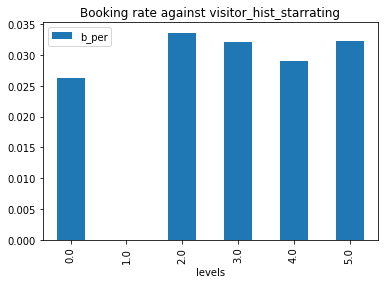

In [ ]:
nanrate(train, 'visitor_hist_starrating')
ratedist(train, 'visitor_hist_starrating', 1, -1)

In [ ]:
feature_names = list(train.columns)
features_to_remove = ["click_bool","booking_bool","gross_bookings_usd","date_time","position", "srch_id", "date_time", "site_id", "random_bool"]
for feature in features_to_remove:
    try:
        feature_names.remove(feature)
    except:
        pass
feature_names

In [ ]:
a = []
b = []
for feature in feature_names:
    a.append([train[feature].isna().sum(), feature])
for item in a:
    if item[0] == 0 :
        pass
    else:
        b.append(item)
count = 0
for item in b:
    b[count] = item[1]
    count+=1

In [ ]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

In [ ]:
for item in b:
    train[item].fillna(0,inplace=True)

In [ ]:
train['prop_review_score'].fillna(3, inplace=True)
train['prop_review_score'][train['prop_review_score']==0]=2.5

train["prop_location_score2"].fillna(0, inplace=True)

avg_srch_score = train["srch_query_affinity_score"].mean()
train["srch_query_affinity_score"].fillna(avg_srch_score, inplace=True)

train["orig_destination_distance"].fillna(1509,inplace=True)

train["visitor_hist_adr_usd"].fillna(0, inplace=True)

train['visitor_hist_starrating_bool'] = pd.notnull(train['visitor_hist_starrating'])

## add feature: comp_rate_sum
for i in range(1,9):
    train['comp'+str(i)+'_rate'].fillna(0, inplace=True)
train['comp_rate_sum'] = train['comp1_rate']
for i in range(2,9):
    train['comp_rate_sum'] += train['comp'+str(i)+'_rate']

## add feature: comp_rate_sum
for i in range(1,9):
    train['comp'+str(i)+'_inv'].fillna(0, inplace=True)
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==1] = 10
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==-1] = 1
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==0] = -1
    train['comp'+str(i)+'_inv'][train['comp'+str(i)+'_inv']==10] = 0
train['comp_inv_sum'] = train['comp1_inv']
for i in range(2,9):
    train['comp_inv_sum'] += train['comp'+str(i)+'_inv']

In [ ]:
def counter(row):
  counter=0
  for i in range(1,9):
    if row['comp'+str(i)+'_inv']==0 and row['comp'+str(i)+'_rate_percent_diff']<1:
      counter+=1
  return counter
#train['count_better'] = train.apply (lambda row: counter(row), axis=1)

Initialise model

In [ ]:
#train and test both from train data 
x = train[feature_names]
y = train["booking_bool"]
#x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size = .75)

49583

In [ ]:
rf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=1.0, random_state=42)

#initialise grid
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 250, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid
{n_estimators=150, min_samples_leaf=1,min_samples_split=10,  n_jobs=-1, max_features='sqrt', max_depth=40}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [90, 107, 125, 143, 161, 178, 196, 214, 232, 250]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)#!!!n_jobs=-1
rf_random.fit(x_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

Evaluate Random Search

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 0.0581 degrees.
Accuracy = -inf%.


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Outputs in Kaggle format

In [ ]:
#gradient_boost_cfdeal with NAs in hotels's infor

test['prop_review_score'].fillna(3, inplace=True)
test['prop_review_score'][test['prop_review_score']==0]=2.5

test["prop_location_score2"].fillna(0, inplace=True)

avg_srch_score = test["srch_query_affinity_score"].mean()
test["srch_query_affinity_score"].fillna(avg_srch_score, inplace=True)

test["orig_destination_distance"].fillna(1509,inplace=True)

test["visitor_hist_adr_usd"].fillna(0, inplace=True)

test['visitor_hist_starrating_bool'] = pd.notnull(test['visitor_hist_starrating'])

## add feature: comp_rate_sum
for i in range(1,9):
    test['comp'+str(i)+'_rate'].fillna(0, inplace=True)
test['comp_rate_sum'] = test['comp1_rate']
for i in range(2,9):
    test['comp_rate_sum'] += test['comp'+str(i)+'_rate']

## add feature: comp_rate_sum
for i in range(1,9):
    test['comp'+str(i)+'_inv'].fillna(0, inplace=True)
    test['comp'+str(i)+'_inv'][test['comp'+str(i)+'_inv']==1] = 10
    test['comp'+str(i)+'_inv'][test['comp'+str(i)+'_inv']==-1] = 1
    test['comp'+str(i)+'_inv'][test['comp'+str(i)+'_inv']==0] = -1
    test['comp'+str(i)+'_inv'][test['comp'+str(i)+'_inv']==10] = 0
test['comp_inv_sum'] = test['comp1_inv']
for i in range(2,9):
    test['comp_inv_sum'] += test['comp'+str(i)+'_inv']

In [ ]:
a = []
b = []
for feature in feature_names:
    a.append([test[feature].isna().sum(), feature])
for item in a:
    if item[0] == 0 :
        pass
    else:
        b.append(item)
count = 0
for item in b:
    b[count] = item[1]
    count+=1
b

for item in b:
    test[item].fillna(0,inplace=True)

Results accuracy

In [ ]:
test = test.fillna(0)

In [ ]:
#test data - UNLABELED
data = test[feature_names]
data['visitor_hist_starrating_step'] = [0 for i in range(4959183)]
data['visitor_hist_starrating_na'] = [0 for i in range(4959183)]

In [ ]:
y_hat = rf_random.predict(x_test)
df(y_hat).describe()

In [ ]:
y_hat = rf_random.predict_proba(x_test)

Saving results

In [ ]:
sub = df({'srch_id':test['srch_id'],'prop_id':test['prop_id'], 'prediction': df(y_hat)[0]})
sub = sub.sort_values(['srch_id','prediction'],ascending = [True,False])
sub.drop(['prediction'],axis =1, inplace= True)
sub.tail()


In [ ]:
sub.to_csv('submission_sample.csv', index = False)

In [ ]:
sample = pd.read_csv('submission_sample.csv')
sample